In [13]:
import os
from functools import partial
from pathlib import Path
from tqdm.notebook import tqdm
import cv2
import numpy as np
import pandas as pd
import scipy
import torch
from fastai.core import defaults
from fastai.vision import load_learner, Image
from matplotlib import pyplot as plt

from video699.screen.common import acc, iou, dice
from video699.screen.evaluation import all_videos_eval, all_frames_visualization, all_video_statistics, evaluate
from video699.screen.fastai_detector import FastAIScreenDetector, SegItemListCustom, SegLabelListCustom
from video699.screen.postprocessing import approximate, draw_polygons
from video699.video.annotated import get_videos, AnnotatedSampledVideoScreenDetector
defaults.device = torch.device('cpu')

In [7]:
model_path = Path(os.getcwd())/'2_time_shrinked_production.pkl'
videos = get_videos()
keys = list(videos.keys())
videos_list = [videos[key] for key in keys]

In [8]:
baseline_parameters = {'lower_bound': 30000, 'upper_bound': 200000, 'factors': [0.1, 0.01]}
erose_dilate_parameters = {'lower_bound': 30000, 'upper_bound': 200000, 'factors': [0.1, 0.01], 'iterations': 40}
ratio_split_baseline = {"lower_bound": 0.7, 'upper_bound': 1.5}

actual_detector = AnnotatedSampledVideoScreenDetector()
pred_detector_best = FastAIScreenDetector(model_path=model_path, methods={'base': baseline_parameters,
                                                        'erose_dilate': erose_dilate_parameters,
                                                        'ratio_split': ratio_split_baseline
                                                       })

### Next ideas
* Find videos with worst IoU automatically
* Find videos with most screen misses automatically
* Find individual frames with worst IoU
* Investigate effect of different post-processing techniques

In [9]:
all_frames = [frame for video in videos_list for frame in video]

In [10]:
actuals = [actual_detector.detect(frame) for frame in all_frames]

In [11]:
preds = [pred_detector_best.detect(frame) for frame in tqdm(all_frames)]

In [16]:
wrong_count, ious, really_bad_ious = evaluate(actuals, preds)

In [17]:
# Manually optimized
print(f"Size of test data: {len(ious)}")
print(f"Number of examples with wrong number of screens: {len(wrong_count)}") 
print(f"Ratio of examples with wrong number of screens to all examples: {len(wrong_count) / len(ious)}")
print(f"Mean iou: {np.nanmean(ious)}")

Size of test data: 409
Number of examples with wrong number of screens: 5
Ratio of examples with wrong number of screens to all examples: 0.012224938875305624
Mean iou: 0.9548199023520707


In [20]:
frames_with_wrong_count = [all_frames[i] for i in wrong_count]

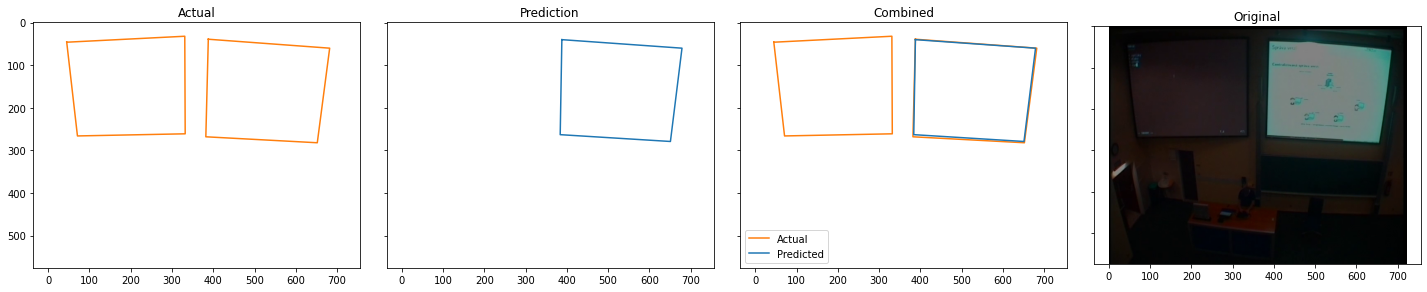

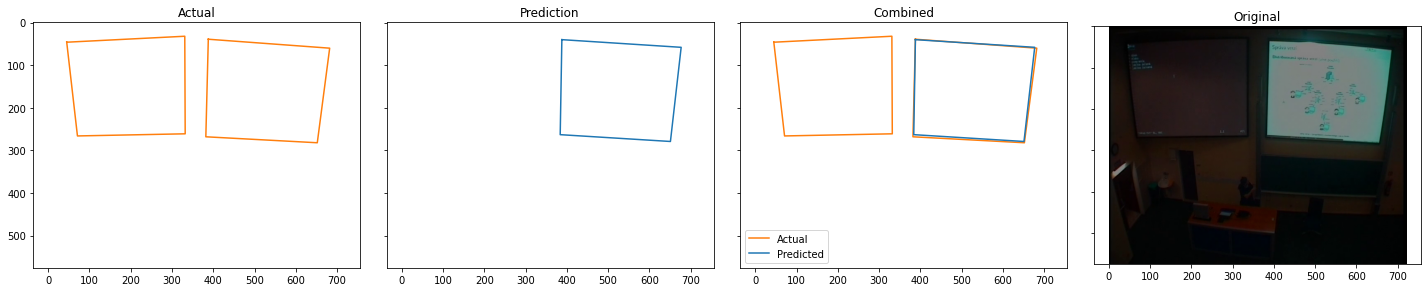

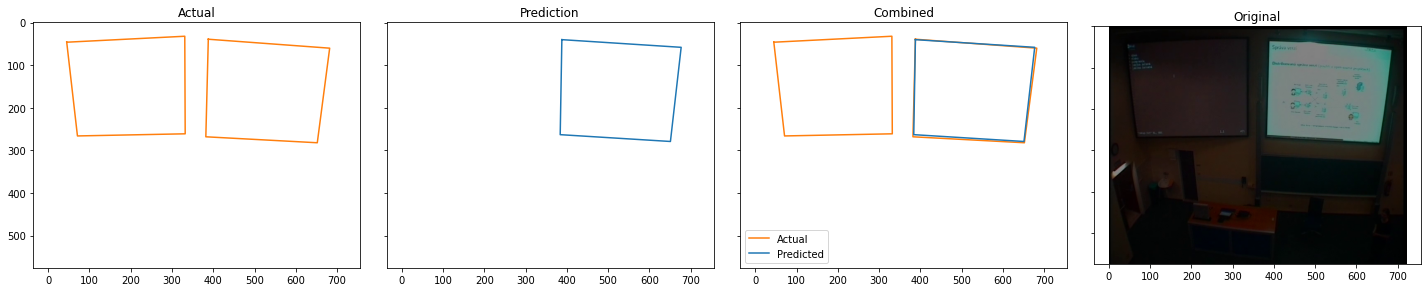

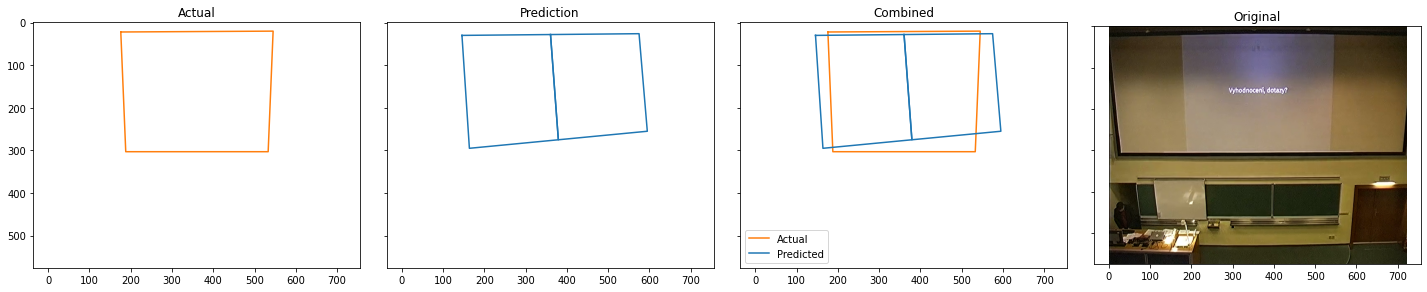

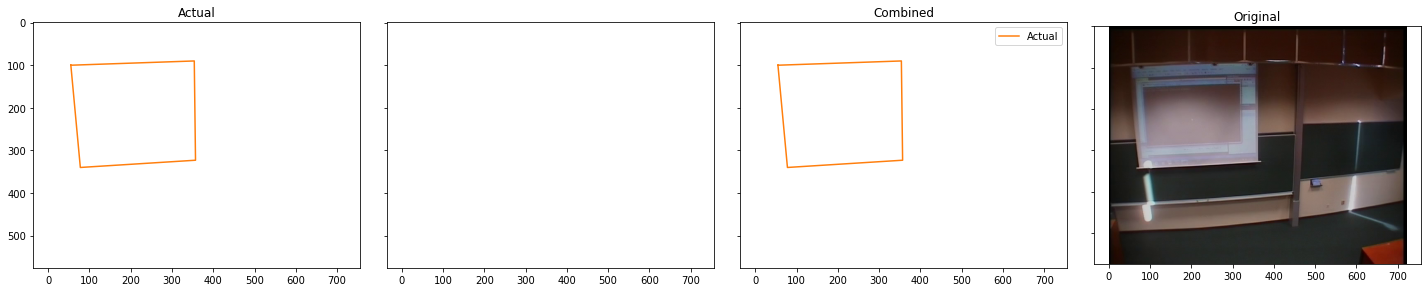

In [21]:
all_frames_visualization(frames_with_wrong_count, actual_detector, pred_detector_best)

In [19]:
all_frames_visualization(really_bad_ious, actual_detector, pred_detector_best)

AttributeError: 'int' object has no attribute 'image'

## Get statistics about dataset

In [ ]:
sizes, ratios = all_video_statistics(videos_list, actual_detector)

In [ ]:
def get_confidence_interval(data, ndigits=0):
    round_n_decimals = partial(round, ndigits=ndigits)
    data = np.array(data)
    mean, std = data.mean(), data.std()
    return map(round_n_decimals, scipy.stats.norm.interval(0.95, loc=mean, scale=std)) 

In [ ]:
lower_area, upper_area = get_confidence_interval(sizes)
lower_area, upper_area

In [ ]:
lower_ratio, upper_ratio = get_confidence_interval(ratios, ndigits=3)
lower_ratio, upper_ratio

## Grid Search

In [ ]:
# Use random search with hyper-opt
lower_bounds = [30000, 36050, 40000]
upper_bounds = [99229, 125000, 175000, 200000]
factor_list = [[0.1, 0.01], [0.1], [0.01], [0.01, 0.02]]

all_settings = [(lower, upper, factors) for lower in lower_bounds for upper in upper_bounds for factors in factor_list]
results = pd.DataFrame(columns=['lower_bound', 'upper_bound', 'factors', 'mean_iou', 'number_of_wrong_screens'])

for setting in all_settings:
    parameters = {'lower_bound': setting[0], 'upper_bound': setting[1], 'factors': setting[2]}
    pred_detector_grid_search = FastAIScreenDetector(model_path, methods={'base': parameters})
    wrong_count, ious, really_bad_ious = all_videos_eval(videos_list, actual_detector, pred_detector_grid_search)
    results.loc[len(results)] = [setting[0], setting[1], setting[2], np.nanmean(ious), len(wrong_count)]

In [ ]:
results

## Multiple images in one batch to better use GPU parallelization

In [ ]:
# test = SegItemListCustom.from_folder(path/'video699/video/annotated', recurse=True)

# learner.data.add_test(test, tfms=None, tfm_y=False)

# preds = learner.get_preds(DatasetType.Test)[0].squeeze().numpy()
# preds

In [ ]:
# np.bitwise_and(zeros.astype(bool), prediction.astype(bool)).sum() / np.bitwise_or(zeros.astype(bool), prediction.astype(bool)).sum()